# _A-B Testing with Explanations_
---
### Greg Howard

AB Testing data has been sourced from a kaggle data set [here](https://www.kaggle.com/saraabdelaal/abtestdata/)

Goals:

1. Explain a-b testing with an example
2. Discuss the statistics supporting the a-b test
3. Show common errors in running a-b tests
---
* Formulate a hypothesis for the test.

The checkout rate with a new website design:  $p$

The checkout rate with the existing website design:  $p_o$

The null hypothesis:  $H_o: p = p_o$

The alternative hypothesis:  $H_a: p \ne p_o$

Threshold for decision regarding statistical significance, i.e. 95% confidence interval:  $\alpha = 0.05$

In [1]:
# import required modules
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
import statsmodels.api as sm
import math
import statistics
import scipy.stats

<IPython.core.display.Javascript object>

user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
dtype: object
   user_id                  timestamp      group landing_page  converted
0   851104 2017-01-21 22:11:48.556739    control     old_page          0
1   804228 2017-01-12 08:01:45.159739    control     old_page          0
2   661590 2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541 2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975 2017-01-21 01:52:26.210827    control     old_page          1
5   936923 2017-01-10 15:20:49.083499    control     old_page          0
6   679687 2017-01-19 03:26:46.940749  treatment     new_page          1
7   719014 2017-01-17 01:48:29.539573    control     old_page          0
8   817355 2017-01-04 17:58:08.979471  treatment     new_page          1
9   839785 2017-01-15 18:11:06.610965  treatment     new_page          1

Data consists of 294478 rows and 5 columns.

There are 290584 uniqu

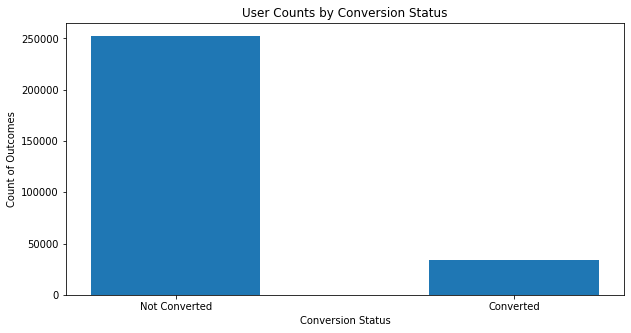

<IPython.core.display.Javascript object>

In [181]:
ab_data = pd.read_csv("AB_Testing_Data/ab_data.csv")
print(ab_data.dtypes)  # check the data types
ab_data.timestamp = pd.to_datetime(
    ab_data.timestamp
)  # convert the timestamp to a datetime format
print(ab_data.head(10))  # display the top 10 rows of the data frame
print("")
print(
    "Data consists of {} rows and {} columns.".format(
        ab_data.shape[0], ab_data.shape[1]
    )
)  # count the rows and columns
print("")
print(
    "There are {} unique values in the user_id column.".format(
        len(ab_data["user_id"].unique())
    )
)  # count the unique users
print("")
# # the value count of how many times a user has appeared in the "user_id" column
user_counts = pd.DataFrame(ab_data["user_id"].value_counts())
user_counts_over_1 = user_counts[
    user_counts["user_id"] > 1
]  # any user that appears twice or more
user_counts_over_1_list = list(user_counts_over_1.index)
ab_data = ab_data[~ab_data["user_id"].isin(user_counts_over_1_list)]
print(
    "There should be only one entry for each user so that they are not sampled twice so {} users were removed.".format(
        len(user_counts_over_1_list)
    )
)
print("")
print(
    "The testing occurred over {} days.".format(
        max(ab_data["timestamp"]) - min(ab_data["timestamp"])
    )
)  # length of the testing
print("")
print(
    "Total count of converted users is {}".format(
        str(ab_data.converted.value_counts()[1])
    )
)
print("")
print(
    "Percent of converted users regardless of landing page is {}%".format(
        round((ab_data.converted.value_counts()[1] / ab_data.shape[0] * 100), 2)
    )
)
categories = ["Not Converted", "Converted"]
counts = ab_data["converted"].value_counts().values

plt.figure(figsize=(10, 5))
plt.bar(categories, counts, width=0.5)
plt.xlabel("Conversion Status")
plt.ylabel("Count of Outcomes")
plt.title("User Counts by Conversion Status")
plt.show()

Are some users in the treatment group seeing the old page when they should be seeing the new page, or vice versa with the control group users seeing the new page?

In [182]:
ctrl_new_page = ab_data[
    (ab_data["group"] == "control") & (ab_data["landing_page"] == "new_page")
]  # users in the control group who were accidentally shown the new page
trmnt_old_page = ab_data[
    (ab_data["group"] == "treatment") & (ab_data["landing_page"] == "old_page")
]  # users in the treatment group who were accidentally shown the old page
# list of all index positions of users shown the wrong page
index_values_to_drop = list(ctrl_new_page.index) + list(trmnt_old_page.index)
print(
    "There were {} users shown the wrong landing page that were removed from the data set.".format(
        len(index_values_to_drop)
    )
)
ab_data.drop(index_values_to_drop, inplace=True)  # drop the users shown the wrong page
ab_data = ab_data.reset_index().drop("index", 1)  # reset the index of the data frame

There were 0 users shown the wrong landing page that were removed from the data set.


<IPython.core.display.Javascript object>

### Data Summary

A control group is needed to assess if other variables have impacted our known base conversion rate during the test.
Sample size affects the precision of our estimate of the actual change in behavior due to the landing page adjustment.  Higher sample size generally means a higher upfront cost though so precision and cost must be balanced.

---

Power analysis is used to gauge how large of a testing group is needed.  The power of a test is represented by: $1 - \beta$

Here $\beta$ is the probability of a type II error (false negative).  

Desired effect size (change in conversion) as an example would be a 1.8% increase from 11.94% to 13.74%.

In [183]:
alpha = 0.05
beta = 0.2
test_power = 1 - beta
effect = sm.stats.proportion_effectsize(0.1374, 0.1194)
# perform power analysis
result = TTestIndPower().solve_power(
    effect, power=test_power, nobs1=None, ratio=1.0, alpha=alpha
)
print(
    "The results of the power analysis indicate that a sample size of {} is required.".format(
        math.ceil(result)
    )
)

The results of the power analysis indicate that a sample size of 5417 is required.


<IPython.core.display.Javascript object>

In [184]:
# convert the control and treatment user groups to numpy arrays
users_control = ab_data[ab_data["group"] == "control"]["user_id"].to_numpy()
users_treatment = ab_data[ab_data["group"] == "treatment"]["user_id"].to_numpy()
# sample for the ab_testing using the numpy random choice function with no replacement
control_sampled = np.random.choice(users_control, math.ceil(result), replace=False)
treatment_sampled = np.random.choice(users_treatment, math.ceil(result), replace=False)
# create data frames of the sampled user_id values then create a new ab_testing_selected data frame
control_sample_data = ab_data[ab_data["user_id"].isin(control_sampled)]
treatment_sample_data = ab_data[ab_data["user_id"].isin(treatment_sampled)]
ab_testing_selected = pd.concat([control_sample_data, treatment_sample_data])
print(
    "There are {} users in the control group and {} users in the treatment group in the testing data.".format(
        ab_testing_selected["group"].value_counts().control,
        ab_testing_selected["group"].value_counts().treatment,
    )
)

There are 5417 users in the control group and 5417 users in the treatment group in the testing data.


<IPython.core.display.Javascript object>

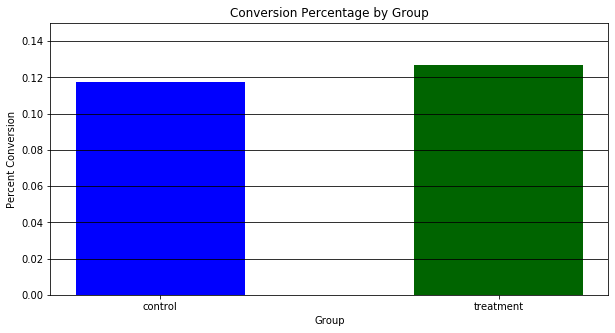

<IPython.core.display.Javascript object>

In [194]:
conversions_by_group = ab_testing_selected.groupby("group")[
    "converted"
]  # conversion rate by group
plt.figure(figsize=(10, 5))
plt.ylim(0, 0.15)
plt.grid(axis="y", color="black")
plt.bar(
    conversions_by_group.mean().index,
    conversions_by_group.mean().values,
    width=0.5,
    color=["blue", "darkgreen"],
)
plt.xlabel("Group")
plt.ylabel("Percent Conversion")
plt.title("Conversion Percentage by Group")
plt.show()

In [246]:
ctrl_sd = np.std(control_sample_data["converted"])
trmnt_sd = np.std(treatment_sample_data["converted"])
total_prop = ab_testing_selected["converted"].mean()  # sampled total conversion rate
z_val = (
    conversions_by_group.mean().values[0] - conversions_by_group.mean().values[1]
) / np.sqrt(
    (total_prop * (1 - total_prop)) * ((1 / 5417) + (1 / 5417))
)  # calculate the two proportion z-test score
p_val_calc = (
    scipy.stats.norm.sf(abs(z_val)) * 2
)  # get the p-value for a two-tailed test with the z_val

<IPython.core.display.Javascript object>

In [252]:
observation_count = [
    control_sample_data["converted"].count(),
    treatment_sample_data["converted"].count(),
]
conversions_success = [
    control_sample_data["converted"].sum(),
    treatment_sample_data["converted"].sum(),
]
# getting the z-test score and associated p-value using the proportions_ztest function
z_statistic, p_value = proportions_ztest(conversions_success, nobs=observation_count)
# calculating the lower and upper confidence interval values for the sampled data
(lower_ctrl, lower_trmnt), (upper_ctrl, upper_trmnt) = proportion_confint(
    conversions_success, nobs=observation_count, alpha=alpha
)
if p_value < alpha:
    print(
        f"The p value, {p_value:.3f}, is less than the alpha value of 0.05."
        "  Reject the null hypothesis in favor of the alternative hypothesis."
    )
else:
    print(
        f"The p value, {p_value:.3f}, is greater than the alpha value of 0.05."
        "  Reject the null hypothesis in favor of the alternative hypothesis."
    )

The p value, 0.134, is greater than the alpha value of 0.05.  Reject the null hypothesis in favor of the alternative hypothesis.


<IPython.core.display.Javascript object>

### Results Summary
---

A two tailed z test for propotions was utilized to assess the results of the ab testing.  The conversion rate with the new landing page proved to be similar enough to the conversion rate with the old landing page given a desired 1.8% increase in conversion as a measure of success.  The increase in the proportion of customers converted with the new landing page did not prove to be statistically significant.